## Этап 1. Открываю данные и получаю общую информацию о датасете

### Импортирую библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from phik import phik_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import catboost as cb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from IPython.display import Image, display

### Открываю данные

In [2]:
try:
    contract_data = pd.read_csv('contract_new.csv')
    personal_data = pd.read_csv('personal_new.csv')
    internet_data = pd.read_csv('internet_new.csv')
    phone_data = pd.read_csv('phone_new.csv')
except:
    contract_data = pd.read_csv('/datasets/contract_new.csv')
    personal_data = pd.read_csv('/datasets/personal_new.csv')
    internet_data = pd.read_csv('/datasets/internet_new.csv')
    phone_data = pd.read_csv('/datasets/phone_new.csv')

- contract_data - информация о договоре
- personal_data - персональные данные клиента
- internet_data - информация об интернет-услугах
- phone_data - информация об услугах телефонии

In [3]:
#открываю датафрейм с информацией о договоре
contract_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [4]:
#открываю датафрейм с персональными данными клиента
personal_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [5]:
#открываю датафрейм с информация об интернет-услугах
internet_data.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [6]:
#открываю датафрейм с информацией об услугах телефонии
phone_data.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [7]:
#функция для приведения названий столбцов к стандарту
def add_underscore_and_lower(column_name):
    result = [column_name[0].lower()]
    for i in range(1, len(column_name)):
        current_char = column_name[i]
        prev_char = column_name[i - 1]
        if current_char.isupper():
            if prev_char.isupper():
                result.append(current_char.lower())
            else:
                result.extend(['_', current_char.lower()])
        else:
            result.append(current_char.lower())
    return ''.join(result)        

In [8]:
contract_data.rename(columns=lambda x: add_underscore_and_lower(x) if isinstance(x, str) else x, 
                     inplace=True)
personal_data.rename(columns=lambda x: add_underscore_and_lower(x) if isinstance(x, str) else x, 
                     inplace=True)
internet_data.rename(columns=lambda x: add_underscore_and_lower(x) if isinstance(x, str) else x, 
                     inplace=True)
phone_data.rename(columns=lambda x: add_underscore_and_lower(x) if isinstance(x, str) else x, 
                     inplace=True)

In [9]:
contract_data.sample(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
6134,3258-SANFR,2019-08-01,No,Month-to-month,No,Credit card (automatic),44.7,268.2
5931,0011-IGKFF,2018-12-01,No,Month-to-month,Yes,Electronic check,98.0,1372.0
3008,8084-OIVBS,2019-03-01,No,One year,No,Mailed check,20.0,231.0


In [10]:
personal_data.sample(3)

,customer_id,gender,senior_citizen,partner,dependents
1464,4283-IVYCI,Male,0,No,No
3203,5879-HMFFH,Female,0,Yes,No
5701,6476-YHMGA,Female,0,Yes,Yes


In [11]:
internet_data.sample(3)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
3025,1357-BIJKI,Fiber optic,No,Yes,No,No,Yes,Yes
2736,9799-CAYJJ,Fiber optic,No,No,No,No,No,No
4330,2619-WFQWU,Fiber optic,No,No,No,No,No,No


In [12]:
phone_data.sample(3)

,customer_id,multiple_lines
714,0810-BDHAW,Yes
3673,8161-QYMTT,Yes
5138,4396-KLSEH,No


### Оценка количества пропусков

In [13]:
#функция проверки датафреймы на пропуски
def isna(data):
    data_isna = data.isna().sum()
    data_isna_percentage = ((data_isna / len(data)) * 100).round(2)
    data_isna_df = pd.DataFrame({
    'Количество пропусков': data_isna,
    'Процент пропусков': data_isna_percentage
}) 
    return data_isna_df[(data_isna_df['Количество пропусков'] > 0)].sort_values(
        by='Количество пропусков', ascending=False)

In [14]:
isna(contract_data)

,Количество пропусков,Процент пропусков


In [15]:
isna(personal_data)

,Количество пропусков,Процент пропусков


In [16]:
isna(internet_data)

,Количество пропусков,Процент пропусков


In [17]:
isna(phone_data)

,Количество пропусков,Процент пропусков


### Оценка количества явных дубликатов

In [18]:
#функция проверки датафрейма на явные дубликаты
def duplicates(data):
    return data.duplicated().sum()

In [19]:
duplicates(contract_data)

0

In [20]:
duplicates(personal_data)

0

In [21]:
duplicates(internet_data)

0

In [22]:
duplicates(phone_data)

0

#### Дубликатов нет.

### Общая информация о данных (информация о договоре)

In [23]:
#общая информация о данных в первом датафрейме
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [24]:
#рассмотрим значения в категориальном признаке
contract_data['type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [25]:
#рассмотрим значение в категориальном признаке
contract_data['paperless_billing'].unique()

array(['Yes', 'No'], dtype=object)

In [26]:
#рассмотрим значение в категориальном признаке
contract_data['payment_method'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

#### Заполнение пропусков

При изменении типов данных в столбце total_charges была обнаружена ошибка, так как часть значений представляют собой строки с пробелом.

In [27]:
contract_data[contract_data['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Есть пропуски в столбце total_charges, в котором содержится общая сумма трат на услуги связи. Так как это самые новые клиенты от 1 февраля 2020 года, заполняем их значениями из monthly_charges, то есть траты на услуги за текущий месяц.

In [28]:
contract_data.loc[contract_data['total_charges'] == ' ', 'total_charges'] = contract_data.loc[
    contract_data['total_charges'] == ' ', 'monthly_charges']

In [29]:
#проверяю корректность заполнения
contract_data[contract_data['customer_id'] == '4472-LVYGI']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55


#### Изменение типов данных

In [30]:
#меняю тип данных 
contract_data['total_charges'] = contract_data['total_charges'].astype('float')

Изменяю тип данных в столбце TotalCharges из строки в вещественное число, так как это численное значение.

In [31]:
contract_data['begin_date'] = pd.to_datetime(
    contract_data['begin_date'], format='%Y-%m-%d')

Изменяю тип данных в столбце BeginDate из строки в datetime, так как это корректно для работы с датой.

In [32]:
#перепроверяю изменения
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


#### Таким образом, в датафрейме с информацией о договоре содержится:
- Ключ customerID (уникальные ID клиента);
- Дата begin_date (дата начала пользования услугами);
- Целевой признак исследования end_date;
- 3 категориальных признака: type (3 значения), paperless_billing (2 значения), payment_method (2 значения);
- 2 количественных признака: monthly_charges и total_charges.

In [33]:
#смотрим распределение количественных признаков
contract_data.describe()

,monthly_charges,total_charges
count,7043.000000,7043.000000
mean,64.761692,2115.377573
std,30.090047,2112.678861
min,18.250000,19.050000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


#### Проверка на аномалии

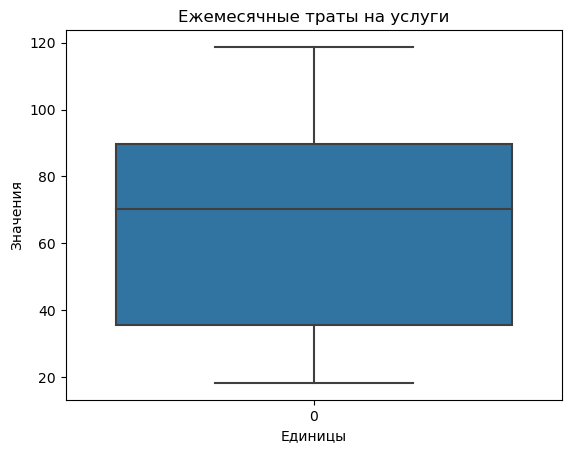

In [34]:
#строим боксплот для количественного признака MonthlyCharges
month_boxplot = sns.boxplot(data=contract_data['monthly_charges'])
month_boxplot.set_title('Ежемесячные траты на услуги')
month_boxplot.set_xlabel('Единицы')
month_boxplot.set_ylabel('Значения')
plt.show()

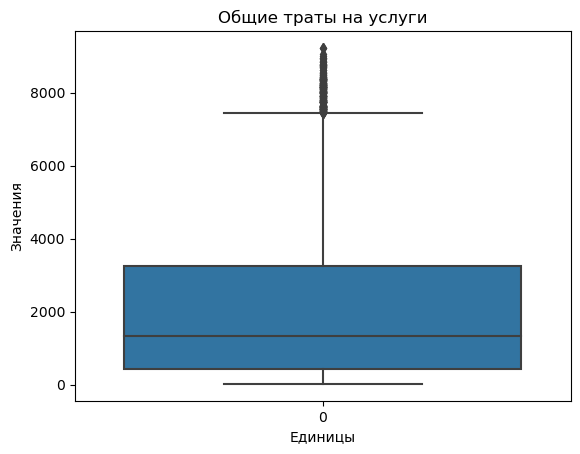

In [35]:
#строим боксплот для количественного признака TotalCharges
tot_charges_boxplot = sns.boxplot(data=contract_data['total_charges'])
tot_charges_boxplot.set_title('Общие траты на услуги')
tot_charges_boxplot.set_xlabel('Единицы')
tot_charges_boxplot.set_ylabel('Значения')
plt.show()

#### В данных нет аномалий.

### Общая информация о данных (персональные данные клиента)

In [36]:
personal_data.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [37]:
#общая информация о данных во втором датафрейме
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [38]:
personal_data['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [39]:
personal_data['senior_citizen'].unique()

array([0, 1])

In [40]:
personal_data['partner'].unique()

array(['Yes', 'No'], dtype=object)

In [41]:
personal_data['dependents'].unique()

array(['No', 'Yes'], dtype=object)

#### B датафрейме с персональными данными содержится:
- Ключ customerID (уникальные ID клиента);
- 4 категориальных признака: gender (2 значения), senior_citizen (2 значения), partner (2 значения),
    dependents (2 значения).

### Общая информация о данных (информация об интернет-услугах)

In [42]:
internet_data.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [43]:
#общая информация о данных в третьем датафрейме
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [44]:
internet_data['internet_service'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

In [45]:
internet_data['online_security'].unique()

array(['No', 'Yes'], dtype=object)

In [46]:
internet_data['online_backup'].unique()

array(['Yes', 'No'], dtype=object)

In [47]:
internet_data['device_protection'].unique()

array(['No', 'Yes'], dtype=object)

In [48]:
internet_data['tech_support'].unique()

array(['No', 'Yes'], dtype=object)

In [49]:
internet_data['streaming_tv'].unique()

array(['No', 'Yes'], dtype=object)

In [50]:
internet_data['streaming_movies'].unique()

array(['No', 'Yes'], dtype=object)

#### B датафрейме с информацией об интернет-услугах:
- Ключ customerID (уникальные ID клиента);
- 7 категориальных признаков: internet_service (2 значения), online_security (2 значения), online_backup (2 значения), device_protection (2 значения), tech_support (2 значения), streaming_tv (2 значения), streaming_movies (2 значения)

### Общая информация о данных (информация об услугах телефонии)

In [51]:
phone_data.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [52]:
#общая информация о данных в четвертом датафрейме
phone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [53]:
phone_data['multiple_lines'].unique()

array(['No', 'Yes'], dtype=object)

### Итого:
- Исходные данные содержат 4 датафрейма с общем ключом столбец customer_id;
- Целевой признак содержится в столбце end_date;
- В датафреймах не обнаружены дубликаты;
- Пустые значения в столбце total_charges объясняются тем, что это самые новые клиенты, пропуски заполнены значения из столбца monthly_charges, то есть текущими расходами за месяц;
- Датафреймы состоят преимущественно из категориальных признаков, выделяются 2 количественных признака: расходы за текущий месяц и общие расходы;
- Аномальные значения в данных отсутствуют;
- Датафреймы с услугами телефонной связи и интернета содержат меньшее количество строк, так как не все клиенты пользуются данными услугами.

### Объединение таблиц

In [54]:
#производим объедениние всех таблиц
df = contract_data.merge(personal_data, on='customer_id', how='left')
df = df.merge(internet_data, on='customer_id', how='left')
df = df.merge(phone_data, on='customer_id', how='left')

Было произведено последование присоединение всех таблиц, начиная с таблиц, которые содержат больше всего строк на основании общего столбца customer_id.

In [55]:
#смотрю итоговую таблицу
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [56]:
#изменяем тип данных
df['end_date'] = df['end_date'].str.replace('No', '2020-02-01')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')

Для удобства работы со столбцом end_date заменяю значения No, то есть для клиентов, которые не закончили пользоваться услугами компании, на текущую дату 2020/02/01. И затем меняю тип данных на datetime.

### Работа с признаками

In [57]:
#создаю новый столбец с целевым признаком
df['client_left'] = df['end_date'].apply(lambda x: 1 if x == pd.Timestamp(2020, 2, 1) else 0)

Таким образом, теперь имеется целевой признак в столбце client_left, где:
- 0 - клиенты, которые перестали продлевать контракт, 
- 1 - клиенты, которые продолжают пользоваться услугами компании.

In [58]:
df.head(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_left
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,NaN,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,1
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,1
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,1


In [59]:
#создание дополнительных столбцов
df['begin_month'] = df['begin_date'].dt.month
df['end_month'] = df['end_date'].dt.month
df['begin_year'] = df['begin_date'].dt.year
df['end_year'] = df['end_date'].dt.year

Создаю несколько дополнительных столбцов для возможности создания дополнительного признака на основе дат.

In [60]:
df['day'] =  (df['end_date'] - df['begin_date']).dt.days

In [61]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,tech_support,streaming_tv,streaming_movies,multiple_lines,client_left,begin_month,end_month,begin_year,end_year,day
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,No,No,NaN,1,1,2,2020,2020,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,No,No,No,1,4,2,2017,2020,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,No,No,No,1,10,2,2019,2020,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,Yes,No,No,NaN,1,5,2,2016,2020,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,No,No,No,1,9,2,2019,2020,153


Создаю дополнительных признак - продолжительность использования услуг компании клиентов в днях.

In [62]:
#функция для нового признака
def service_column(data):
    if pd.isna(data['multiple_lines']):
        return 'internet_only'
    elif pd.isna(data['internet_service']):
        return 'phone_only'
    else:
        return 'both'

In [63]:
df['service'] = df.apply(service_column, axis=1)

Создаю дополнительный признак - услуги, которыми пользуются клиенты (только интернет, только телефон, обе)

In [64]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,streaming_tv,streaming_movies,multiple_lines,client_left,begin_month,end_month,begin_year,end_year,day,service
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,No,NaN,1,1,2,2020,2020,31,internet_only
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,No,No,1,4,2,2017,2020,1036,both
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,No,No,1,10,2,2019,2020,123,both
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,No,NaN,1,5,2,2016,2020,1371,internet_only
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,No,No,1,9,2,2019,2020,153,both


In [65]:
#удаляю стобцы, которые могут повлиять на утечку целевого признака
df = df.drop(['end_date', 'end_month', 'end_year'], axis=1)

Оставляю только столбцы, связанные с датой начала пользования услугами.

In [66]:
#проверяю результат изменений
df.head()

,customer_id,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_left,begin_month,begin_year,day,service
0,7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,No,No,No,No,NaN,1,1,2020,31,internet_only
1,5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,Yes,No,No,No,No,1,4,2017,1036,both
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,No,No,No,No,No,1,10,2019,123,both
3,7795-CFOCW,2016-05-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,...,Yes,Yes,No,No,NaN,1,5,2016,1371,internet_only
4,9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,...,No,No,No,No,No,1,9,2019,153,both


### Пропуски

In [67]:
isna(df)

,Количество пропусков,Процент пропусков
internet_service,1526,21.67
online_security,1526,21.67
online_backup,1526,21.67
device_protection,1526,21.67
tech_support,1526,21.67
streaming_tv,1526,21.67
streaming_movies,1526,21.67
multiple_lines,682,9.68


Пропуски в объединенном датафрейма связаны с тем, что не все клиенты используют услуги интернета или телефона.

In [68]:
#функция заполнения пропусков
def fill_nan(data):
    data = data.fillna('not_used')
    return data

In [69]:
df = fill_nan(df)

Пропуски заменяю на 0, равносильные параметру No.

In [70]:
df.head()

,customer_id,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_left,begin_month,begin_year,day,service
0,7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,No,No,No,No,not_used,1,1,2020,31,internet_only
1,5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,Yes,No,No,No,No,1,4,2017,1036,both
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,No,No,No,No,No,1,10,2019,123,both
3,7795-CFOCW,2016-05-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,...,Yes,Yes,No,No,not_used,1,5,2016,1371,internet_only
4,9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,...,No,No,No,No,No,1,9,2019,153,both


## Этап 2. Исследовательский анализ данных

In [71]:
#формирую отдельную таблицу ушедших клиентов
client_left_yes = df.loc[df['client_left'] == 0]

In [72]:
#формирую отдельную таблицу оставшихся клиентов
client_left_no = df.loc[df['client_left'] == 1]

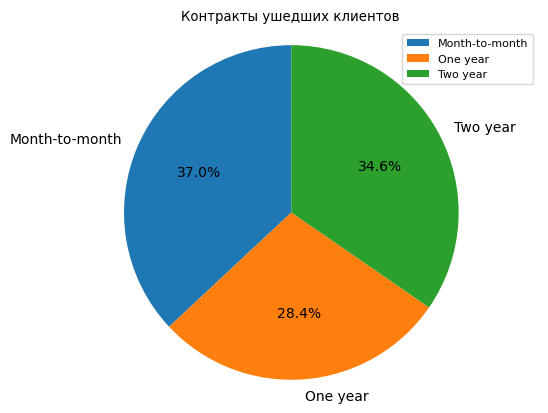

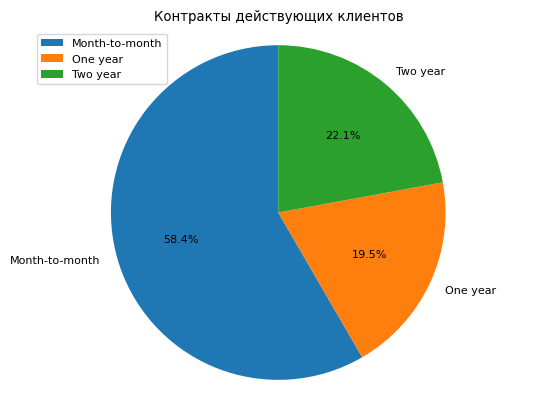

In [73]:
#круговая диаграмма по типу контракта для ушедших клиентов
client_left_yes_type = client_left_yes.pivot_table(index='type', values='client_left', aggfunc='count')
fig, ax = plt.subplots()
ax.pie(client_left_yes_type['client_left'], labels=client_left_yes_type.index, 
                            autopct='%1.1f%%', startangle=90)
plt.rcParams['font.size'] = 8   
ax.legend(loc='upper right')
ax.axis('equal')
ax.set_title('Контракты ушедших клиентов')
plt.show()

#круговая диаграмма по типу контракта для оставшихся клиентов
client_left_no_type = client_left_no.pivot_table(index='type', values='client_left', aggfunc='count')
fig, ax = plt.subplots()
ax.pie(client_left_no_type['client_left'], labels=client_left_no_type.index, 
                            autopct='%1.1f%%', startangle=90)
plt.rcParams['font.size'] = 8   
ax.legend(loc='upper left')
ax.axis('equal')
ax.set_title('Контракты действующих клиентов')
plt.show()

Среди ушедших клиентов доли по контрактам распределены достаточно равномерно:
- Лидируют ежемесячные тарифы 37%;
- На втором месте двухлетние 34.6%;
- Наименее популярны годичные 28.4%.

Среди действующих клиентов доли по контрактам распределены следующим образом:
- C большим отрывом лидируют ежемесячные тарифы 58.4%;
- На втопом месте двухлетние тарифы 22.1%;
- Наименее популярные годичные 19.5%.

Таким образом, ранжирование популряности тарифных планов среди ушедших и действующих клиентов похоже, но для действующих клиентов популярность ежемесячных оплат относительно других тарифов сильно выше, чем у ушедших.

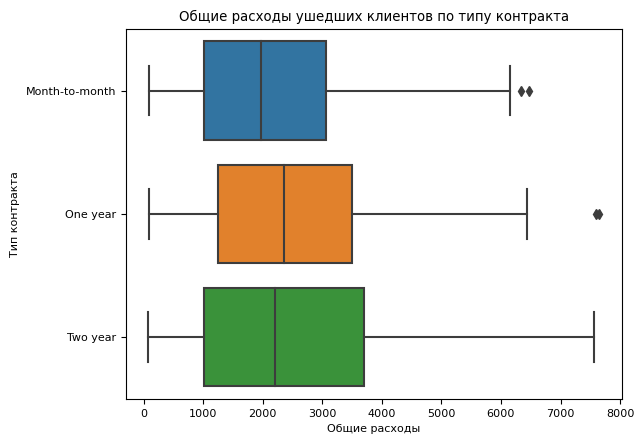

In [74]:
#боксплот по общим расходам для ушедших клиентов по типу контракта
order = ['Month-to-month', 'One year', 'Two year']
type_boxplot_1 = sns.boxplot(x='total_charges',
                            y='type',
                            data=client_left_yes,
                            order=order)
type_boxplot_1.set_title('Общие расходы ушедших клиентов по типу контракта')                             
type_boxplot_1.set_xlabel('Общие расходы')
type_boxplot_1.set_ylabel('Тип контракта')
plt.show()

Среди ушедших клиентов общие расходы для разных тарифов в целом сопоставимые. Можно отметить, что наибольшие медианные расходы встречаются у годичных контрактов. Также диапазон значений для 2-летних и годичных тарифов выше, чем у ежемесячных.

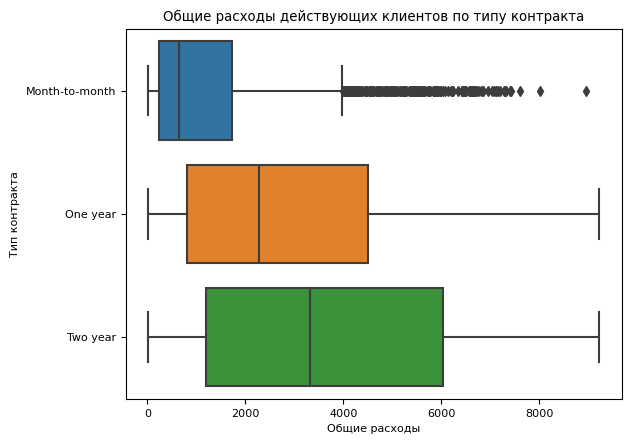

In [75]:
#боксплот по общим расходам для действующих клиентов по типу контракта
type_boxplot_2 = sns.boxplot(x='total_charges',
                            y='type',
                            data=client_left_no)
type_boxplot_2.set_title('Общие расходы действующих клиентов по типу контракта')                             
type_boxplot_2.set_xlabel('Общие расходы')
type_boxplot_2.set_ylabel('Тип контракта')
plt.show()

Медианные значения общих расходов у клиентов с ежемесячным тарифом значительно ниже, чем у годичных и двухлетних.
В отличие от ушедших клиентов, в разрезе действующих клиентов наибольшие медианные расходы соответствуют двухлетним тарифам.

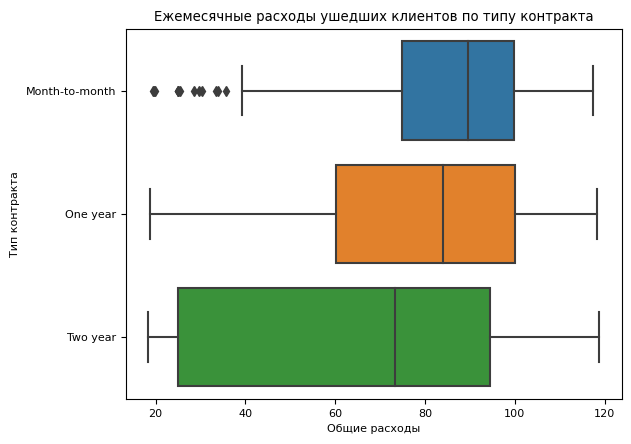

In [76]:
#боксплот по ежемесячных расходам для ушедших клиентов по типу контракта
type_boxplot_3 = sns.boxplot(x='monthly_charges',
                            y='type',
                            data=client_left_yes,
                            order=order)
type_boxplot_3.set_title('Ежемесячные расходы ушедших клиентов по типу контракта')                             
type_boxplot_3.set_xlabel('Общие расходы')
type_boxplot_3.set_ylabel('Тип контракта')
plt.show()

Медианные ежемесячные расходы на тарифах с помесячной оплатой выше, чем у годичных и двухлетних, что в целом логично, долгосрочные контракты, как правило, предполагают более выгодные условия.

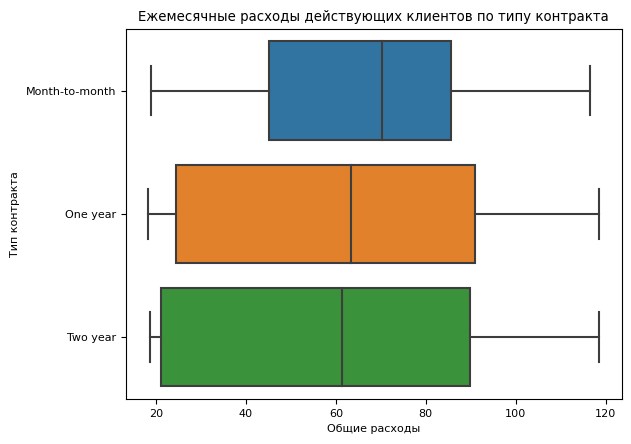

In [77]:
#боксплот по ежемесячных расходам для действующих клиентов по типу контракта
type_boxplot_4 = sns.boxplot(x='monthly_charges',
                            y='type',
                            data=client_left_no,
                            order=order)
type_boxplot_4.set_title('Ежемесячные расходы действующих клиентов по типу контракта')                             
type_boxplot_4.set_xlabel('Общие расходы')
type_boxplot_4.set_ylabel('Тип контракта')
plt.show()

Для действующих клиентов ежемесячные расходы по краткосрочным контрактам также выше, чем по долгосрочным.

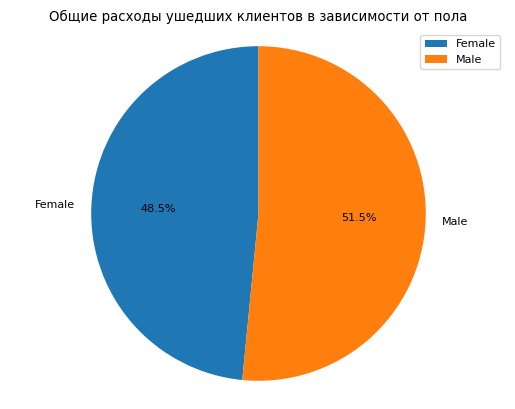

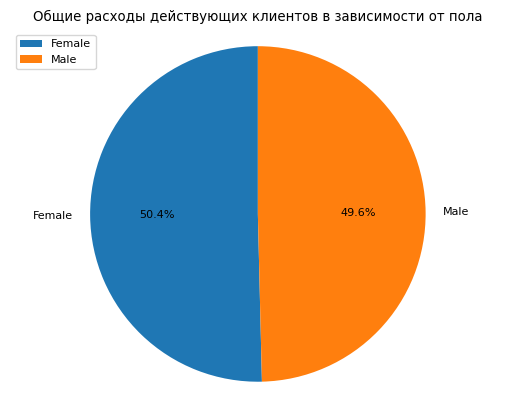

In [78]:
#круговая диаграмма по общим расходам для ушедших клиентов в зависимости от пола
client_left_yes_gender = client_left_yes.pivot_table(index='gender', values='total_charges', aggfunc='sum')
fig, ax = plt.subplots()
ax.pie(client_left_yes_gender['total_charges'], labels=client_left_yes_gender.index, 
                            autopct='%1.1f%%', startangle=90)
plt.rcParams['font.size'] = 8   
ax.legend(loc='upper right')
ax.axis('equal')
ax.set_title('Общие расходы ушедших клиентов в зависимости от пола')
plt.show()

#круговая диаграмма по общим расходам для оставшихся клиентов в зависимости от пола
client_left_no_gender = client_left_no.pivot_table(index='gender', values='total_charges', aggfunc='sum')
fig, ax = plt.subplots()
ax.pie(client_left_no_gender['total_charges'], labels=client_left_no_gender.index, 
                            autopct='%1.1f%%', startangle=90)
plt.rcParams['font.size'] = 8   
ax.legend(loc='upper left')
ax.axis('equal')
ax.set_title('Общие расходы действующих клиентов в зависимости от пола')
plt.show()

Среди действующих клиентов общие расходы между полами поделены практически поровну. Среди ушедших клиентов общие расходы клиентов мужчин были на 1,5% больше, чем у клиентов-женщин.

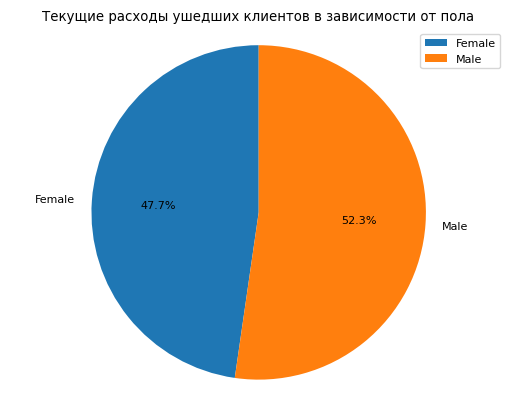

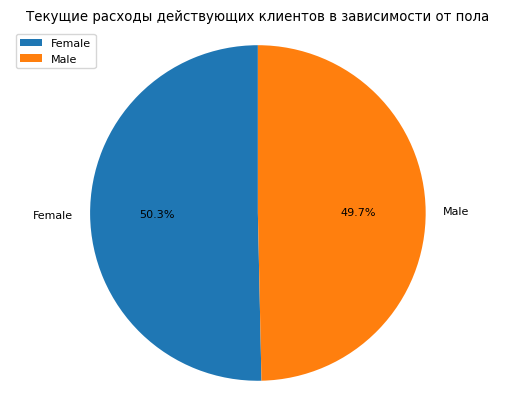

In [79]:
#круговая диаграмма по текущим расходам для ушедших клиентов в зависимости от пола
client_left_yes_gender = client_left_yes.pivot_table(index='gender', values='monthly_charges', aggfunc='sum')
fig, ax = plt.subplots()
ax.pie(client_left_yes_gender['monthly_charges'], labels=client_left_yes_gender.index, 
                            autopct='%1.1f%%', startangle=90)
plt.rcParams['font.size'] = 8   
ax.legend(loc='upper right')
ax.axis('equal')
ax.set_title('Текущие расходы ушедших клиентов в зависимости от пола')
plt.show()

#круговая диаграмма по текущим расходам для ушедших клиентов в зависимости от пола
client_left_no_gender = client_left_no.pivot_table(index='gender', values='monthly_charges', aggfunc='sum')
fig, ax = plt.subplots()
ax.pie(client_left_no_gender['monthly_charges'], labels=client_left_no_gender.index, 
                            autopct='%1.1f%%', startangle=90)
plt.rcParams['font.size'] = 8   
ax.legend(loc='upper left')
ax.axis('equal')
ax.set_title('Текущие расходы действующих клиентов в зависимости от пола')
plt.show()

Текущие расходы между ушедшими и действующими клиентами-мужчинами и клиентами-женщинами распределены похожим образом как и общие расходы. 

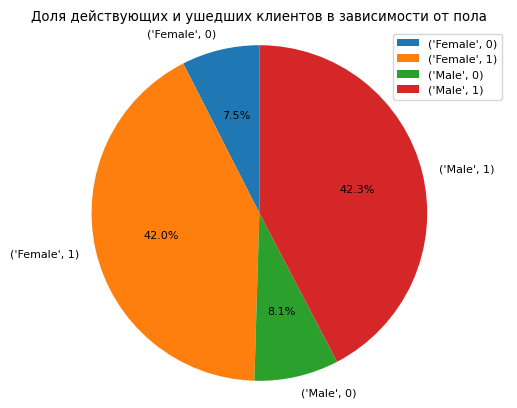

In [80]:
gender_left = df.pivot_table(index=['gender', 'client_left'], values='customer_id', aggfunc='count')
fig, ax = plt.subplots()
ax.pie(gender_left['customer_id'], labels=gender_left.index, 
                            autopct='%1.1f%%', startangle=90)
plt.rcParams['font.size'] = 8   
ax.legend(loc='upper right')
ax.axis('equal')
ax.set_title('Доля действующих и ушедших клиентов в зависимости от пола')
plt.show()

Среди всех клиентов соотношение действующих/ушедших клиентов мужчин и женщин практически одинаковое: 
- 7.5% клиентов это ушедшедшие клиенты-женщины, 8.1% - мужчины;
- 42% клиентов это действующие клиенты-женщины, 42.3% - мужчины.

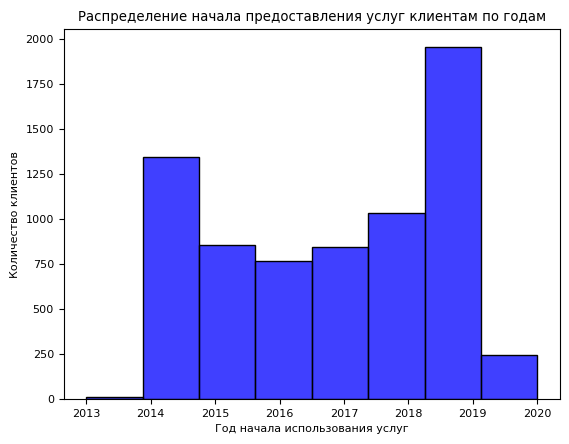

In [81]:
#гистограма для столбца begin_year
sns.histplot(df['begin_year'], bins=8, kde=False, color='blue')
plt.xlabel('Год начала использования услуг')
plt.ylabel('Количество клиентов')
plt.title('Распределение начала предоставления услуг клиентам по годам')
plt.show()

Видим, что было 2 периода высокого роста числа клиентов: 2014 и 2019 год. Низкие значения за 2013 и 2020 объясняются отсутствием данных за весь год.

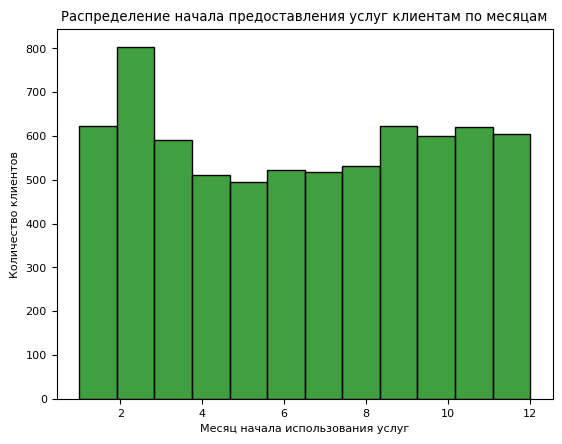

In [82]:
#гистограма для столбца begin_month
sns.histplot(df['begin_month'], bins=12, kde=False, color='green')
plt.xlabel('Месяц начала использования услуг')
plt.ylabel('Количество клиентов')
plt.title('Распределение начала предоставления услуг клиентам по месяцам')
plt.show()

Видим, что в феврале клиенты чаще всего начинали пользоваться услугами компании.

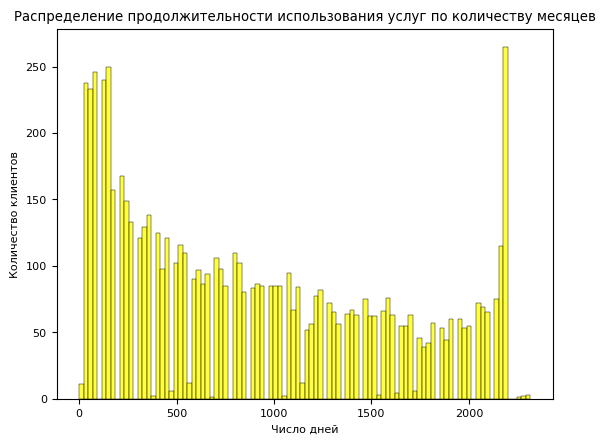

In [83]:
#гистограма для столбца month
sns.histplot(df['day'], bins=100, kde=False, color='yellow')
plt.xlabel('Число дней')
plt.ylabel('Количество клиентов')
plt.title('Распределение продолжительности использования услуг по количеству месяцев')
plt.show()

Видим интересную особенность, что большая часть пользователей стала клиентами компании 6 лет назад в определенный месяц и на протяжении длительного периода продолжала пользоваться услугами.

### Корреляционный анализ

In [84]:
df.head()

,customer_id,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_left,begin_month,begin_year,day,service
0,7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,No,No,No,No,not_used,1,1,2020,31,internet_only
1,5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,Yes,No,No,No,No,1,4,2017,1036,both
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,No,No,No,No,No,1,10,2019,123,both
3,7795-CFOCW,2016-05-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,...,Yes,Yes,No,No,not_used,1,5,2016,1371,internet_only
4,9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,...,No,No,No,No,No,1,9,2019,153,both


In [85]:
#создаю копию датафрейма для проведения one-hot encoding
df_ohe = df.copy()

In [86]:
df_ohe.head()

,customer_id,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_left,begin_month,begin_year,day,service
0,7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,No,No,No,No,not_used,1,1,2020,31,internet_only
1,5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,Yes,No,No,No,No,1,4,2017,1036,both
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,No,No,No,No,No,1,10,2019,123,both
3,7795-CFOCW,2016-05-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,...,Yes,Yes,No,No,not_used,1,5,2016,1371,internet_only
4,9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,...,No,No,No,No,No,1,9,2019,153,both


In [87]:
#удаляю нерелевантные анализу признаки
df_ohe = df_ohe.drop(['customer_id', 'begin_date', 'total_charges', 'monthly_charges'], axis=1)

In [88]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   type               7043 non-null   object
 1   paperless_billing  7043 non-null   object
 2   payment_method     7043 non-null   object
 3   gender             7043 non-null   object
 4   senior_citizen     7043 non-null   int64 
 5   partner            7043 non-null   object
 6   dependents         7043 non-null   object
 7   internet_service   7043 non-null   object
 8   online_security    7043 non-null   object
 9   online_backup      7043 non-null   object
 10  device_protection  7043 non-null   object
 11  tech_support       7043 non-null   object
 12  streaming_tv       7043 non-null   object
 13  streaming_movies   7043 non-null   object
 14  multiple_lines     7043 non-null   object
 15  client_left        7043 non-null   int64 
 16  begin_month        7043 non-null   int64 


interval columns not set, guessing: ['senior_citizen', 'client_left', 'begin_month', 'begin_year', 'day']


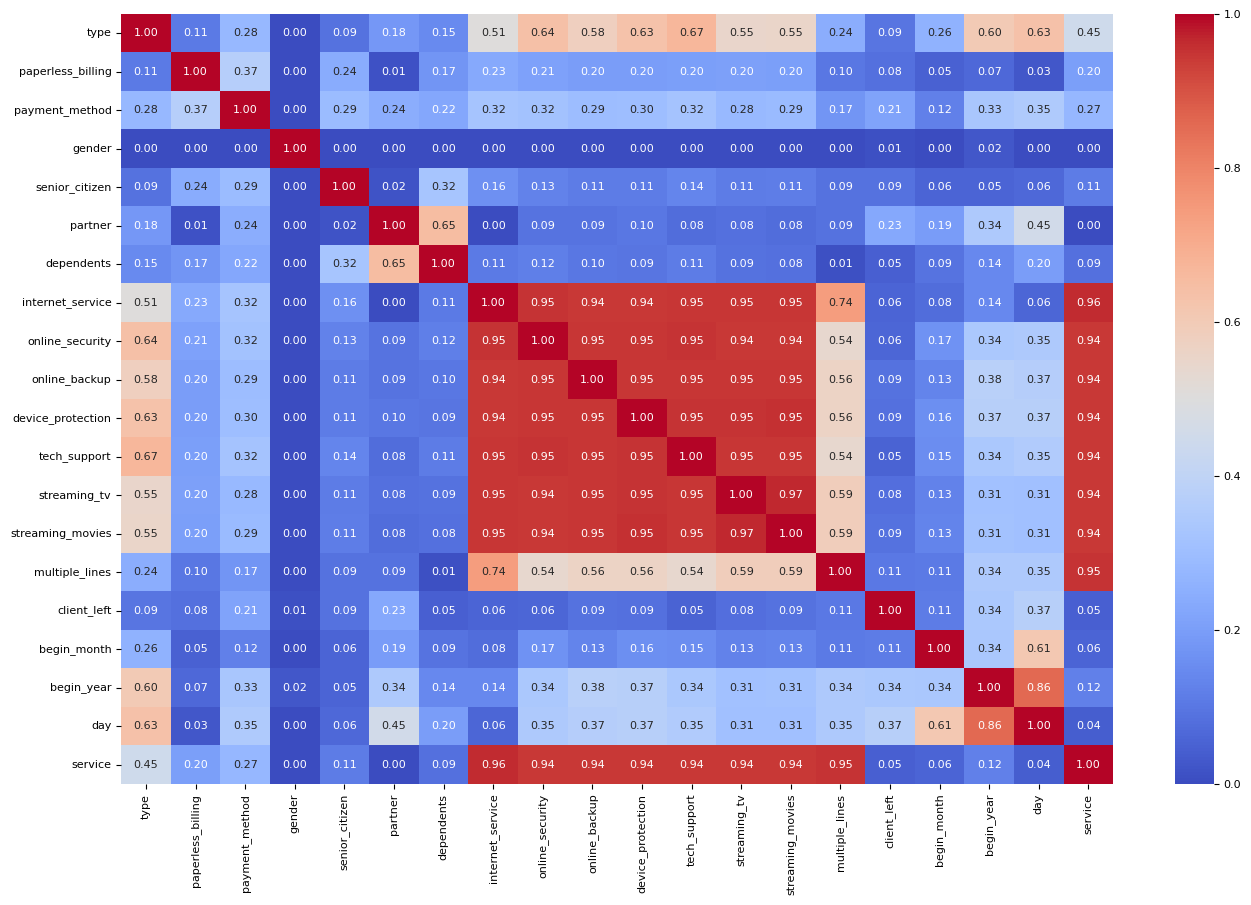

In [89]:
phik_corr_matrix = df_ohe.phik_matrix()
plt.figure(figsize=(16, 10))
sns.heatmap(phik_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Видим, что столбец gender никак не коррелирует с другими признаками, можно будет удалить его из дальнейшего исследования.

### Баланс классов целевого признака

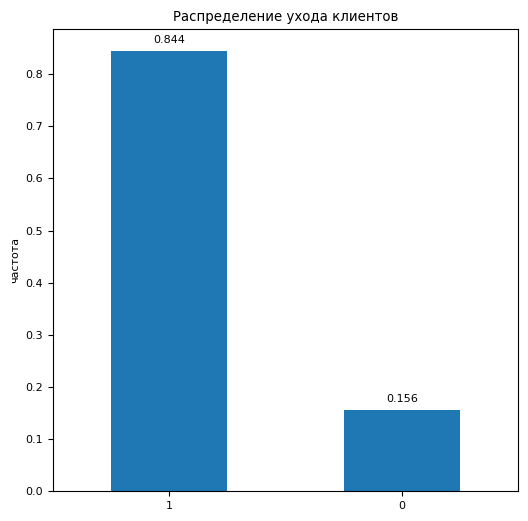

In [90]:
barplot1 = df['client_left'].value_counts(normalize=True).plot(kind='bar',
                                                               figsize=(6,6),
                                                               title='Распределение ухода клиентов')
                                                       
                                                       
plt.xticks(rotation=0)
plt.ylabel('частота')
for bar in barplot1.patches:
    barplot1.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
    
plt.show()

В данном исследовании наблюдается дисбаланс классов: 15.6% клиентов из всей выборки перестали быть клиентами компании, 84.4% - остались.
Так как целевой метрикой исследования является ROC-AUC дисбаланс классов не устраняется.

## Этап 3. Обучение моделей

### Подготовка признаков для обучения модели

In [91]:
df.head()

,customer_id,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_left,begin_month,begin_year,day,service
0,7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,No,No,No,No,not_used,1,1,2020,31,internet_only
1,5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,Yes,No,No,No,No,1,4,2017,1036,both
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,No,No,No,No,No,1,10,2019,123,both
3,7795-CFOCW,2016-05-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,...,Yes,Yes,No,No,not_used,1,5,2016,1371,internet_only
4,9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,...,No,No,No,No,No,1,9,2019,153,both


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   7043 non-null   object        
 12  online_security    7043 non-null   object        
 13  online_backup      7043 non-null   object        
 14  device_p

In [93]:
df_ml = df.copy()

In [94]:
#удаляю нерелеватные обучению признаки
df_ml = df_ml.drop(['customer_id', 'begin_date', 'gender', 'begin_month', 'begin_year'], axis=1)

Удалены признаки:
- customer_id, т.к. это уникальный идентификатор клиента;
- begin_date, begin_month, begin_year, т.к. может привести к утечке целевого признака;
- gender, т.к. не имеет связи с другими параметрами.

In [95]:
#определяем признаки и целевой признак
features = df_ml.drop('client_left', axis=1)
target = df_ml['client_left']

In [96]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   senior_citizen     7043 non-null   int64  
 6   partner            7043 non-null   object 
 7   dependents         7043 non-null   object 
 8   internet_service   7043 non-null   object 
 9   online_security    7043 non-null   object 
 10  online_backup      7043 non-null   object 
 11  device_protection  7043 non-null   object 
 12  tech_support       7043 non-null   object 
 13  streaming_tv       7043 non-null   object 
 14  streaming_movies   7043 non-null   object 
 15  multiple_lines     7043 non-null   object 
 16  day                7043 

In [97]:
#разделяем обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=100723)

- Соотношение 1:3
- RANDOM STATE = 100723

In [98]:
#проверяю размерность выборок
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(5282, 18)
(1761, 18)
(5282,)
(1761,)


In [99]:
#отделяю категориальные признаки, к которым нужно применить OHE
categorical_features = ['type', 'paperless_billing', 'payment_method', 'partner',
                        'dependents', 'internet_service', 'online_security', 'online_backup',
                        'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 
                        'multiple_lines', 'service']
                                                                 

In [100]:
#применяю fit и transform в OHE на обучающей выборке
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
encoded_data = encoder_ohe.fit_transform(features_train[categorical_features])

In [101]:
#возвращаю кодированный датафрейм
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=
                          encoder_ohe.get_feature_names_out(categorical_features))

In [102]:
#восстанавливаю индексы
original_index = features_train.index
encoded_df.index = original_index
encoded_df.head()

,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,partner_Yes,dependents_Yes,internet_service_Fiber optic,internet_service_not_used,...,tech_support_Yes,tech_support_not_used,streaming_tv_Yes,streaming_tv_not_used,streaming_movies_Yes,streaming_movies_not_used,multiple_lines_Yes,multiple_lines_not_used,service_internet_only,service_phone_only
5979,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1635,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4496,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6281,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2645,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [103]:
#объединяю с исходной таблицей признаков
features_train = features_train.merge(encoded_df, left_index=True, right_index=True)

In [104]:
#удаляю столбцы признаков до кодировки
features_train = features_train.drop(categorical_features, axis=1)

In [105]:
features_train.head()

,monthly_charges,total_charges,senior_citizen,day,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,...,tech_support_Yes,tech_support_not_used,streaming_tv_Yes,streaming_tv_not_used,streaming_movies_Yes,streaming_movies_not_used,multiple_lines_Yes,multiple_lines_not_used,service_internet_only,service_phone_only
5979,19.65,1145.59,0,1614,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1635,69.95,224.54,0,92,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4496,89.75,6462.00,0,2191,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6281,20.60,123.60,0,184,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2645,19.80,19.80,0,31,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [106]:
#выделяю количественные признаки
numeric_features = ['monthly_charges', 'total_charges', 'day']

In [107]:
#масштабирую количественные признаки
scaler = StandardScaler()
scaler.fit(features_train[numeric_features])

StandardScaler()

In [108]:
features_train[numeric_features] = scaler.transform(features_train[numeric_features])

In [109]:
features_train.head()

,monthly_charges,total_charges,senior_citizen,day,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,...,tech_support_Yes,tech_support_not_used,streaming_tv_Yes,streaming_tv_not_used,streaming_movies_Yes,streaming_movies_not_used,multiple_lines_Yes,multiple_lines_not_used,service_internet_only,service_phone_only
5979,-1.495365,-0.463658,0,1.030452,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1635,0.177624,-0.899089,0,-1.185137,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4496,0.836176,2.049702,0,1.870396,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6281,-1.463768,-0.946809,0,-1.051212,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2645,-1.490376,-0.995881,0,-1.273935,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [110]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 5979 to 711
Data columns (total 30 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   monthly_charges                         5282 non-null   float64
 1   total_charges                           5282 non-null   float64
 2   senior_citizen                          5282 non-null   int64  
 3   day                                     5282 non-null   float64
 4   type_One year                           5282 non-null   float64
 5   type_Two year                           5282 non-null   float64
 6   paperless_billing_Yes                   5282 non-null   float64
 7   payment_method_Credit card (automatic)  5282 non-null   float64
 8   payment_method_Electronic check         5282 non-null   float64
 9   payment_method_Mailed check             5282 non-null   float64
 10  partner_Yes                             5282 non-null   fl

### Обучение модели

LGBM Classifier с подбором гиперпараметров через GridSearchCV.

In [111]:
%%time
lgbm = LGBMClassifier(random_state=100723)
param_grid = {
    'num_leaves': [50, 100],
    'learning_rate': [0.1, 0.2, 0.4],
    'n_estimators': [50, 100],
    'max_depth': [2, 4]
}
grid_model_lgbm = GridSearchCV(lgbm, param_grid, cv=4, scoring='roc_auc', verbose=0)
grid_model_lgbm.fit(features_train, target_train)

CPU times: user 55.6 s, sys: 16.1 s, total: 1min 11s
Wall time: 17.3 s


GridSearchCV(cv=4, estimator=LGBMClassifier(random_state=100723),
             param_grid={'learning_rate': [0.1, 0.2, 0.4], 'max_depth': [2, 4],
                         'n_estimators': [50, 100], 'num_leaves': [50, 100]},
             scoring='roc_auc')

In [112]:
print('ROC-AUC модели:', grid_model_lgbm.best_score_)
print('Гиперпараметры модели:', grid_model_lgbm.best_params_)

ROC-AUC модели: 0.8739869246828861
Гиперпараметры модели: {'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 50}


CatBoost Classifier с подбором гиперпараметров через GridSearchCV.

In [113]:
%%time
catboost = cb.CatBoostClassifier(random_state=100723, eval_metric='AUC', verbose=False)

param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.1, 0.2],
    'depth': [2, 4],
    'l2_leaf_reg': [x for x in range (2,6)]
}
grid_model_cb = GridSearchCV(catboost, param_grid, cv=4, scoring='roc_auc')
grid_model_cb.fit(features_train, target_train)

CPU times: user 35.2 s, sys: 27.5 s, total: 1min 2s
Wall time: 22.5 s


GridSearchCV(cv=4,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fd8c0b46730>,
             param_grid={'depth': [2, 4], 'iterations': [100, 200],
                         'l2_leaf_reg': [2, 3, 4, 5],
                         'learning_rate': [0.1, 0.2]},
             scoring='roc_auc')

In [114]:
print('AUC-ROC модели:', grid_model_cb.best_score_)
print('Гиперпараметры модели:', grid_model_cb.best_params_)

AUC-ROC модели: 0.9009350563727763
Гиперпараметры модели: {'depth': 4, 'iterations': 200, 'l2_leaf_reg': 2, 'learning_rate': 0.2}


In [115]:
#сохраняю лучшую модель
best_model_cb = grid_model_cb.best_estimator_

- Лучший результат показала модель CatBoost Classifier ;
- ROC-AUC на кросс-валидации 0.9009 ;
- Лучшие параметры: depth - 4, iterations - 200, learning rate - 0.2, l2 leaf reg - 2.

### Тестирование модели

In [116]:
#на тестовой выборке произвожу transform для OHE
test_encoded = encoder_ohe.transform(features_test[categorical_features])

In [117]:
#возвращаю кодированный датафрейм
encoded_test = pd.DataFrame(test_encoded.toarray(), 
                            columns=encoder_ohe.get_feature_names_out(categorical_features))

In [118]:
#восстанавливаю индексы
test_index = features_test.index
encoded_test.index = test_index
encoded_test.head()

,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,partner_Yes,dependents_Yes,internet_service_Fiber optic,internet_service_not_used,...,tech_support_Yes,tech_support_not_used,streaming_tv_Yes,streaming_tv_not_used,streaming_movies_Yes,streaming_movies_not_used,multiple_lines_Yes,multiple_lines_not_used,service_internet_only,service_phone_only
2849,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
5186,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3195,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2536,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
122,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [119]:
#добавляю кодированные признаки в датафрейм тестовых признаков
features_test = features_test.merge(encoded_test, left_index=True, right_index=True)

In [120]:
#удаляю признаки до кодировки
features_test = features_test.drop(categorical_features, axis=1)

In [121]:
#масштабирую количественные признаки
features_test[numeric_features] = scaler.transform(features_test[numeric_features])

In [122]:
features_test.head()

,monthly_charges,total_charges,senior_citizen,day,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,...,tech_support_Yes,tech_support_not_used,streaming_tv_Yes,streaming_tv_not_used,streaming_movies_Yes,streaming_movies_not_used,multiple_lines_Yes,multiple_lines_not_used,service_internet_only,service_phone_only
2849,-1.473746,-0.890079,0,-0.787729,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
5186,-0.936593,-0.919082,1,-1.096339,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3195,0.530182,-0.635098,0,-0.917287,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2536,-1.307445,-0.658381,0,-0.033671,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
122,0.325632,-0.829377,0,-1.096339,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Модель CatBoost на тестовой выборке.

In [123]:
probabilities_test = best_model_cb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc_test = roc_auc_score(target_test, probabilities_one_test)

In [124]:
print('AUC-ROC на тестовой выборке', auc_roc_test)

AUC-ROC на тестовой выборке 0.920176336645897


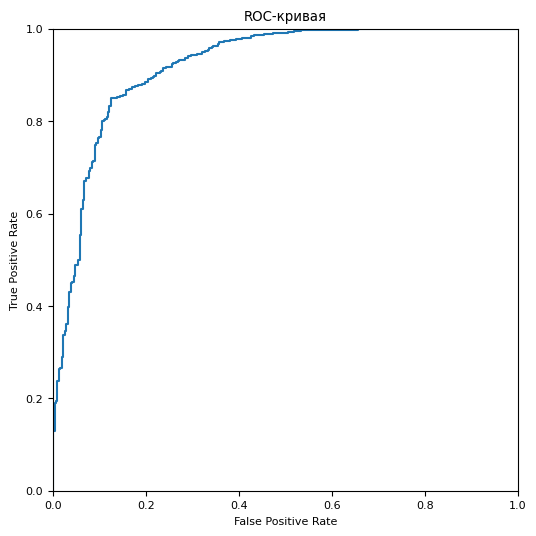

In [125]:
#ROC-кривая
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [126]:
#строю матрицу ошибок
pred_test = best_model_cb.predict(features_test)
cm = confusion_matrix(target_test, pred_test)
print('Матрица ошибок:')
print(cm)

Матрица ошибок:
[[ 171  142]
 [  18 1430]]


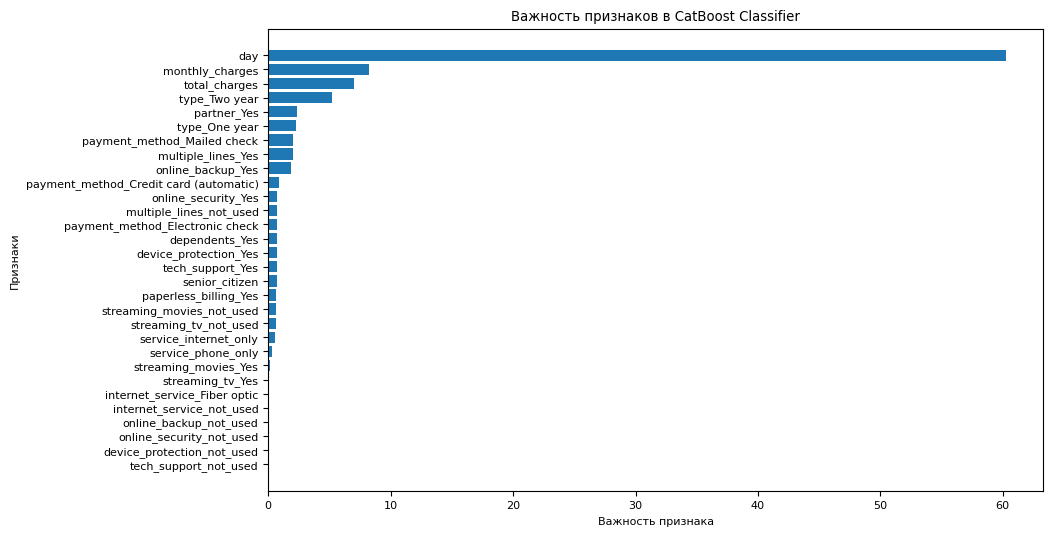

In [127]:
#график важности признаков
feature_importance = best_model_cb.get_feature_importance()
feature_names = best_model_cb.feature_names_ if hasattr(best_model_cb, 'feature_names_') else None
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[idx] if feature_names else f'Feature {idx}' for idx in sorted_idx])
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Важность признаков в CatBoost Classifier')
plt.show()

In [128]:
accuracy = accuracy_score(target_test, pred_test)
print('Точность модели:', accuracy)

Точность модели: 0.9091425326519024


### ВЫВОД

Был произведен исследовательский анализ данных, по результатам которого выявлено, что:
- Популряность разных тарифных планов среди ушедших и действующих клиентов похожа по структуре, но для действующих клиентов популярность ежемесячных оплат относительно других тарифов сильно выше, чем у ушедших;
- Среди ушедших клиентов наибольшие медианные общие расходы встречаются у годичных контрактов, среди действующих - у клиентов с двухлетними тарифами;
- Самые высокие текущие расходы у ежемесячных тарифов;
- Среди всех клиентов соотношение действующих/ушедших клиентов мужчин и женщин практически одинаковое;
- Было 2 периода высокого роста числа клиентов: 2014 и 2019 год; 
- Большая часть пользователей стала клиентами компании 6 лет назад в определенный месяц и на протяжении длительного периода продолжала пользоваться услугами.

Были добавлены новые признаки:
- month (количество месяцев использования услуг компании)
- service (тип услуги, которую использует клиент)

При обучении модели были исключены следующие признаки:
- признаки, связанные с датой начала пользования услугами;
- gender, так как пол не коррелирует с другими признаками;
- customer_id, так как это уникальный номер клиента.

Перед обучением модели к категориальным признакам был применен OneHotEncoding, количественные признаки масштабированы.

Для обучения были выбраны 2 модели градиентного бустинга LGMB Classifier и CatBoost Classifier с подбором гиперпараметров через GridSearchCV.

Лучший результат на обучающей выборке показала модель CatBoost Classifier - 0.9009.
Гиперпараметры: depth - 4, iterations - 200, learning rate - 0.2, l2 leaf reg - 2. 
Random state - 100723.

На тестовой выборке модель показала AUC-ROC - 0.9201. 